<a href="https://colab.research.google.com/github/msskx/deepLearning/blob/main/AQIPreForGRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import torch
from torch import nn

In [5]:
from matplotlib import pyplot as plt

In [6]:
df=pd.read_csv(r'/content/drive/MyDrive/时间序列/Air_AQI_yanan.csv')

In [7]:
df.tail()

,Date,Quality_grade,AQI,AQI_rank,PM2_5,PM10,SO2,NO2,CO,O3
3237,2022-12-27,良,52,95,30,53,8,39,0.98,30
3238,2022-12-28,良,56,136,33,56,12,45,1.00,23
3239,2022-12-29,优,49,96,29,52,10,44,1.07,27
3240,2022-12-30,良,67,163,45,67,12,52,1.26,26
3241,2022-12-31,良,78,171,56,78,9,55,1.27,28


In [8]:
df.columns

Index(['Date', 'Quality_grade', 'AQI', 'AQI_rank', 'PM2_5', 'PM10', 'SO2',
       'NO2', 'CO', 'O3'],
      dtype='object')

In [9]:
data=pd.DataFrame(df.loc[:,['Date','AQI', 'PM2_5', 'PM10', 'SO2','NO2', 'CO', 'O3']])

In [10]:
data=data.set_index('Date')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fde8484e9d0>,
      dtype=object)

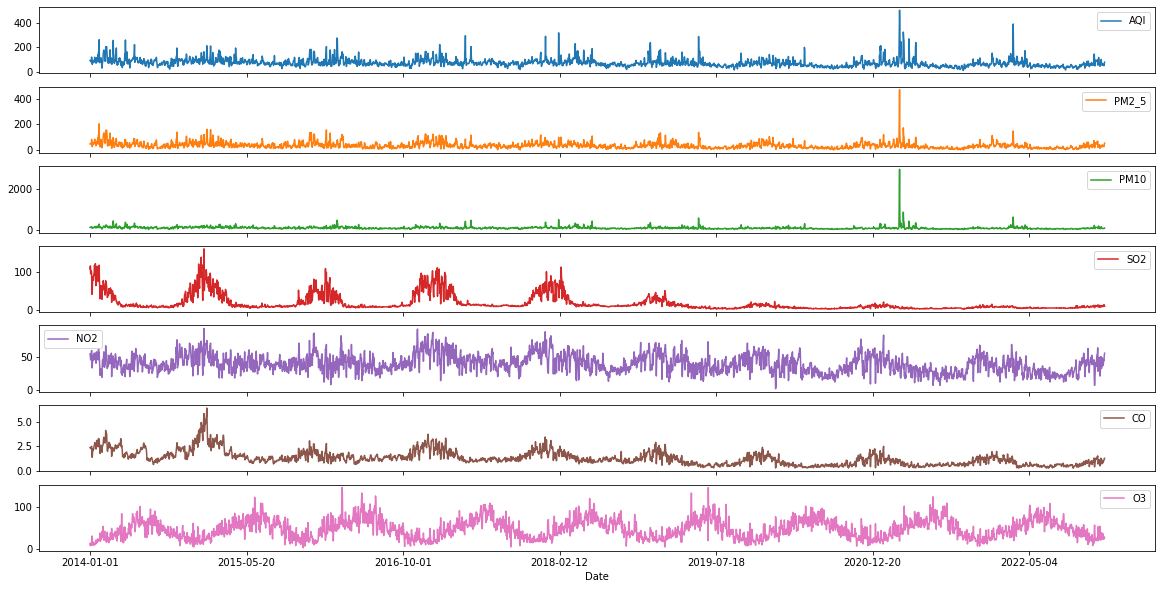

In [11]:

data.plot(subplots=True,figsize=(20,10))


In [12]:
data.head()

,AQI,PM2_5,PM10,SO2,NO2,CO,O3
Date,,,,,,,
2014-01-01,92,50,115,107,54,2.37,13
2014-01-02,87,50,106,115,50,2.34,8
2014-01-03,85,51,114,94,45,2.26,14
2014-01-04,80,49,106,97,51,2.40,12
2014-01-05,82,51,107,103,54,2.37,10


In [13]:
seq_length = 30 #观测30天
delay = 7 #预测7天

In [14]:
### 滑动窗口生成数据

In [15]:
data_=[]
for i in range(len(data) - seq_length - delay):
    data_.append(data.iloc[i:i+seq_length+delay])

In [16]:
data_[0].shape#每条训练数据有37条数据7个特征

(37, 7)

In [17]:
data_ = np.array([df.values for df in data_])

In [18]:
data_.shape

(3205, 37, 7)

In [19]:
np.random.shuffle(data_) # 乱序

In [20]:
x = data_[:,:seq_length,:] #高维切片

In [21]:
y = data_[:,-delay:,0] #取出delay个预测数据，并预测AQI特征

In [22]:
x.shape,y.shape

((3205, 30, 7), (3205, 7))

In [23]:
from sklearn.model_selection import train_test_split   

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [25]:
x_train.shape,x_test.shape

((2243, 30, 7), (962, 30, 7))

In [26]:
mean = x_train.mean(axis=0)#对列处理
std = x_train.std(axis=0)

In [27]:
x_train = (x_train-mean)/std

In [28]:
x_test = (x_test-mean)/std

In [29]:
x_train.shape

(2243, 30, 7)

In [30]:
class MYDataset(torch.utils.data.Dataset):
    def __init__(self,features,labels):
        self.features = features
        self.labels = labels
    def __getitem__(self,index):
        return self.features[index],self.labels[index]
    def __len__(self):
        return len(self.features)


In [31]:
train_ds=MYDataset(x_train,y_train)
test_ds=MYDataset(x_test,y_test)

In [32]:
train_dl=torch.utils.data.DataLoader(train_ds,batch_size=32)
test_dl=torch.utils.data.DataLoader(test_ds,batch_size=32)

In [33]:
next(iter(train_dl))[0].shape,next(iter(train_dl))[1].shape

(torch.Size([32, 30, 7]), torch.Size([32, 7]))

In [34]:
# 创建模型
from torch import functional as F

In [44]:
class Net(nn.Module):
  def __init__(self,hidden_size):
    super(Net,self).__init__()
    self.rnn = nn.GRU(x_train.shape[-1],hidden_size,batch_first=True)
    self.fc1 = nn.Linear(hidden_size,128)
    self.fc2 = nn.Linear(128,7)
    self.dropout = nn.Dropout(p=0.5) 
  def forward(self,inputs):
    inputs = inputs.to(torch.float32)
    f_o , s_o = self.rnn(inputs) # s_o中间状态
    s_o = s_o[-1]
    x = torch.relu(self.fc1(s_o))
    x = self.dropout(x)
    x = self.fc2(x)
    return torch.squeeze(x)


In [45]:
hidden_size = 64
model = Net(hidden_size)

In [46]:
model

Net(
  (rnn): GRU(7, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [47]:
if torch.cuda.is_available():
  model.to('cuda')

In [48]:
loss_fn = nn.MSELoss()

In [49]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [50]:
def fit(epoch, model, trainloader, testloader):
    total = 0
    running_loss = 0
    
    model.train()
    for x, y in trainloader:
        if torch.cuda.is_available():
            x, y = x.to('cuda'), y.to('cuda')
        # x = x.float()
        x = x.to(torch.float64)
        y = y.to(torch.float64)
        y_pred = model(x)
        y_pred = y_pred.to(torch.float64)

        loss = loss_fn(y_pred, y)
        # print(type(y_pred))
        # print(type(y))
        # print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            total += y.size(0)
            running_loss += loss.item()
#    exp_lr_scheduler.step()
    epoch_loss = running_loss / len(trainloader.dataset)
        
        
    test_total = 0
    test_running_loss = 0 
    
    model.eval()
    with torch.no_grad():
        for x, y in testloader:
            if torch.cuda.is_available():
                x, y = x.to('cuda'), y.to('cuda')
   
            x = x.to(torch.float64)
            y = y.to(torch.float64)
            y_pred = model(x)
            y_pred = y_pred.to(torch.float64)

            loss = loss_fn(y_pred, y)
            test_total += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    
        
    print('epoch: ', epoch, 
          'loss： ', round(epoch_loss, 3),
          'test_loss： ', round(epoch_test_loss, 3),
             )
        
    return epoch_loss, epoch_test_loss

In [51]:
epochs = 1000

In [52]:
train_loss = []
test_loss = []

for epoch in range(epochs):
    epoch_loss, epoch_test_loss = fit(epoch,
                                      model,
                                      train_dl,
                                      test_dl)
    train_loss.append(epoch_loss)
    test_loss.append(epoch_test_loss)

epoch:  0 loss：  164.744 test_loss：  73.861
epoch:  1 loss：  43.195 test_loss：  37.983
epoch:  2 loss：  42.711 test_loss：  46.883
epoch:  3 loss：  41.248 test_loss：  37.356
epoch:  4 loss：  36.786 test_loss：  34.534
epoch:  5 loss：  35.744 test_loss：  33.118
epoch:  6 loss：  35.666 test_loss：  32.687
epoch:  7 loss：  35.084 test_loss：  31.715
epoch:  8 loss：  34.133 test_loss：  30.93
epoch:  9 loss：  33.525 test_loss：  30.247
epoch:  10 loss：  33.657 test_loss：  29.981
epoch:  11 loss：  33.176 test_loss：  29.87
epoch:  12 loss：  32.897 test_loss：  29.714
epoch:  13 loss：  32.518 test_loss：  29.446
epoch:  14 loss：  31.934 test_loss：  29.628
epoch:  15 loss：  31.996 test_loss：  29.449
epoch:  16 loss：  32.041 test_loss：  29.741
epoch:  17 loss：  32.157 test_loss：  29.435
epoch:  18 loss：  31.969 test_loss：  29.378
epoch:  19 loss：  31.882 test_loss：  29.49
epoch:  20 loss：  32.049 test_loss：  29.414
epoch:  21 loss：  31.806 test_loss：  29.545
epoch:  22 loss：  31.713 test_loss：  29.386


In [55]:
from matplotlib import pyplot as plt

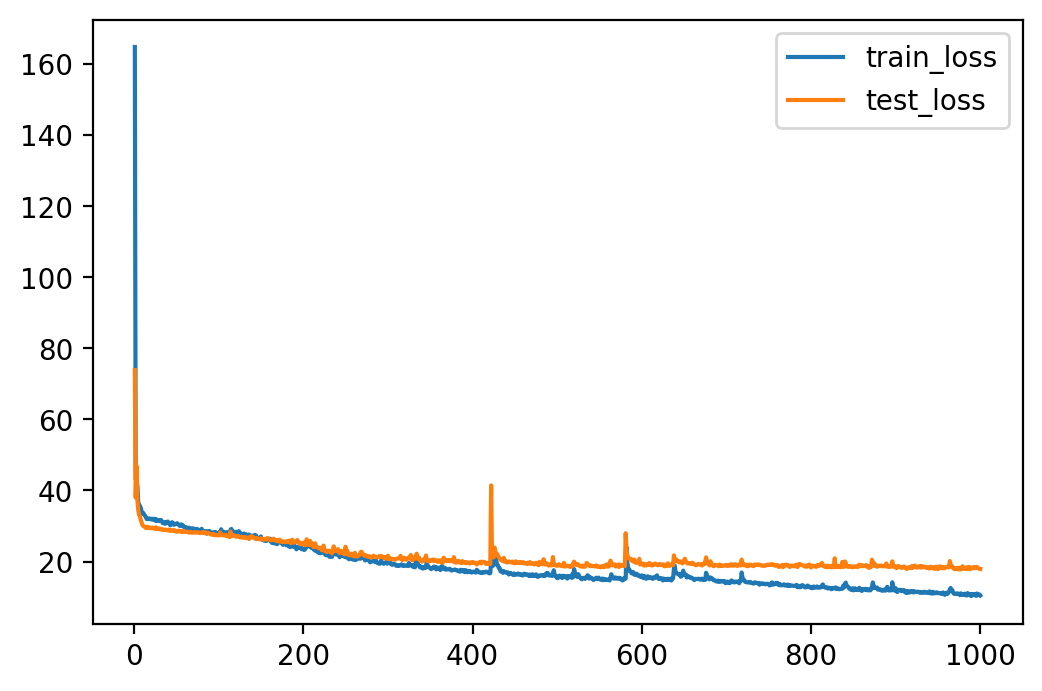

In [90]:
plt.figure(dpi=200)
plt.plot(range(1,len(train_loss)+1),train_loss,label="train_loss")
plt.plot(range(1,len(train_loss)+1),test_loss,label="test_loss")
plt.legend()

In [58]:
# 批量预测

In [59]:
x_test.shape

(962, 30, 7)

In [69]:
yp=model(torch.from_numpy(x_test))

In [70]:
y_test[0]

array([143., 165., 159., 164., 105.,  74.,  85.])

In [86]:
s = yp[0].detach().numpy()

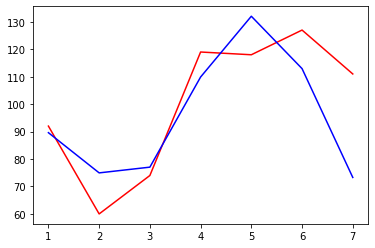

In [92]:
plt.plot(range(1,8),y_test[2], 'r',label='true')
plt.plot(range(1,8),yp[2].detach().numpy(), 'b',label='pre')

In [93]:
result = []
for test_b,_ in test_dl:
  pred_b = model(test_b)
  result.append(pred_b.detach().numpy())

In [96]:
np.concatenate(result).shape

(962, 7)

In [97]:
y_test.shape

(962, 7)